# PROJECT 3

## Part 1: Prediction quality vs feature selection

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LassoCV, Lasso, LogisticRegression, LogisticRegressionCV
from pandas import DataFrame
from sklearn.model_selection import train_test_split
import random
from copy import deepcopy
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, confusion_matrix, f1_score
from sklearn.feature_selection import SelectKBest, f_classif

Hyperparameter $\lambda$ are instead $\alpha$ in LassoCV

`alpha_` contains hyperparameter that achieved lowest MSE

`alphas_` contains all tested hyperparameters

Coeffs of `Lasso` can be found in `coef_`

`mse_path_` a `(len(alphas_) x n_folds)` matrix storing test error on each fold

Vectors **e** and **s** can easily be computed from `mse_path_`

In [2]:
# Function to simulate data from the thesis
def simulate_data(n, p, rng, sparsity=0.95, SNR=2.0, beta_scale=5.0):
    """Simulate data for Project 3, Part 1.

    Parameters
    ----------
    n : int
        Number of samples
    p : int
        Number of features
    rng : numpy.random.Generator
        Random number generator (e.g. from `numpy.random.default_rng`)
    sparsity : float in (0, 1)
        Percentage of zero elements in simulated regression coefficients
    SNR : positive float
        Signal-to-noise ratio (see explanation above)
    beta_scale : float
        Scaling for the coefficient to make sure they are large

    Returns
    -------
    X : `n x p` numpy.array
        Matrix of features
    y : `n` numpy.array
        Vector of responses
    beta : `p` numpy.array
        Vector of regression coefficients
    """
    X = rng.standard_normal(size=(n, p))
    
    q = int(np.ceil((1.0 - sparsity) * p))
    beta = np.zeros((p,), dtype=float)
    beta[:q] = beta_scale * rng.standard_normal(size=(q,))
    
    sigma = np.sqrt(np.sum(np.square(X @ beta)) / (n - 1)) / SNR

    y = X @ beta + sigma * rng.standard_normal(size=(n,))

    # Shuffle columns so that non-zero features appear
    # not simply in the first (1 - sparsity) * p columns
    idx_col = rng.permutation(p)
    
    return X[:, idx_col], y, beta[idx_col]

Suggestions for parameters:<br>
- `p` - something large, e.g. `500` or `1000`<br>
- `n` - vary compared to p, e.g. iterate through `[200, 500, 750]` if `p = 1000`<br>
what truly matters is the ratio `p/n`, <br>
if you change `p`, adjust choices of `n`<br>
- `sparsity` - vary for a few choices e.g. `[0.75, 0.9, 0.95, 0.99]`<br>
- `SNR` - fix at something reasonable like `2` or `5`<br>
- `beta_scale` - fix at maybe `5` or `10`<br>

Questions
- How des the MSE of the $\lambda_{min}$ and $\lambda_{1se}$ models behave for different $n$ and sparsity levels?
- What differences between sensitivity/specificity computed from the $\lambda_{min}$ and the $\lambda_{1se}$ models can you observe?
- How do different choices for `n` and `sparisty` affect the relationship of sensitivity/specifity?

In [3]:
p = 500 # 500
nmin = 100 # 100
nmax = p-nmin
nn = 3# 3
n = np.linspace(nmin, nmax, nn)
sparsity = [0.75, 0.9, 0.95, 0.99]
# sparsity = [0.75]
SNR = 2
beta_scale = 5
print(n)

[100. 250. 400.]


In [4]:
rng = np.random.default_rng()
n_runs = 10
n_folds = 5
train_frac = 0.8
# Dictionary with the alpha_min and alpha_1se.
# Each list will contain the data for each value of n
MSEtrain = {'min':[], '1se':[]}
MSEtest = {'min':[], '1se':[]}
sensitivity = {'min':[], '1se':[]}
specificity = {'min':[], '1se':[]}

# With len(n)=3 and len(sparsity)=4 and 5 repeats,
# we will run thourgh 60 datasets, be aware
for cn in n:
    MSE_train_list = [[], []]
    MSE_test_list = [[], []]
    sensitivity_list = [[], []]
    specificity_list = [[], []]
    for csparsity in sparsity:
        MSE_train_1se = []
        MSE_train_min = []
        MSE_test_1se = []
        MSE_test_min = []
        sensitivity_min = []
        sensitivity_1se = []
        specificity_min = []
        specificity_1se = []

        for _ in range(n_runs):
            X, y, beta = simulate_data(int(cn), p, rng, csparsity, SNR, beta_scale)
            train_idx = int(np.floor(cn*train_frac))
            # split into training and test
            trainX = X[0:train_idx]
            trainy = y[0:train_idx]
            testX = X[train_idx:]
            testy= y[train_idx:]
            # fit lassoCV to training data
            lasso = LassoCV(cv=n_folds).fit(trainX, trainy) #, random_state=0
            # extract betas
            beta_est_min = lasso.coef_
            non_zero_idx = np.nonzero(beta_est_min)[0]
            selected_features_est_min = deepcopy(beta_est_min)   
            selected_features_est_min[non_zero_idx] = 1 
            # code from thesis to get alpha_min and alpha_1se
            cv_mean = np.mean(lasso.mse_path_, axis=1)
            cv_std = np.std(lasso.mse_path_, axis=1)
            idx_min_mean = np.argmin(cv_mean)
            idx_alpha = np.where(
                (cv_mean <= cv_mean[idx_min_mean] + cv_std[idx_min_mean] / np.sqrt(n_folds)) &
                (cv_mean >= cv_mean[idx_min_mean])
            )[0][0]
            alpha_1se = lasso.alphas_[idx_alpha]

            # extract data of MSE from alpha_min and alpha_1se
            # jag tror det här är rätt men inte helt 100
            MSE_train_min.append(cv_mean[idx_min_mean])
            MSE_train_1se.append(cv_mean[idx_alpha])

            # predict test data, with alpha_min
            test_pred_min = lasso.predict(testX)
            MSE_test_min.append(mean_squared_error(testy, test_pred_min))           

            # refit on training data with specific alpha and predict on test data
            upd_lasso = Lasso(alpha_1se).fit(trainX, trainy)
            test_pred_1se = upd_lasso.predict(testX)
            MSE_test_1se.append(mean_squared_error(testy, test_pred_1se))
            # extract betas from lasso model with alpha_1se
            beta_est_1se = upd_lasso.coef_
            non_zero_idx = np.nonzero(beta_est_1se)[0]
            selected_features_est_1se = deepcopy(beta_est_1se)
            selected_features_est_1se[non_zero_idx] = 1

            # make the true betas a 1-0-vector
            non_zero_idx = np.nonzero(beta)[0]
            selected_features_true = deepcopy(beta)
            selected_features_true[non_zero_idx] = 1
            
            cm_min = confusion_matrix(selected_features_true, selected_features_est_min)
            cm_1se = confusion_matrix(selected_features_true, selected_features_est_1se)
            # TP = confusion[1,1] # true positives
            # TN = confusion[0,0] # true negatives
            # FP = confusion[0,1] # false positives
            # FN = confusion[1,0] # false negatives
            sensitivity_min.append(cm_min[1,1]/(cm_min[1,0]+cm_min[1,1]))
            sensitivity_1se.append(cm_1se[1,1]/(cm_1se[1,0]+cm_1se[1,1]))
            specificity_min.append(cm_min[0,0]/(cm_min[0,0]+cm_min[0,1]))
            specificity_1se.append(cm_1se[0,0]/(cm_1se[0,0]+cm_1se[0,1]))
            # print(sensitivity, specificity)
            


        # det här skäms jag över, förlåt
        MSE_train_list[0].append(MSE_train_min)
        MSE_train_list[1].append(MSE_train_1se)
        MSE_test_list[0].append(MSE_test_min)
        MSE_test_list[1].append(MSE_test_1se)
        sensitivity_list[0].append(sensitivity_min)
        sensitivity_list[1].append(sensitivity_1se)
        specificity_list[0].append(specificity_min)
        specificity_list[1].append(specificity_1se)
    MSEtrain['min'].append(MSE_train_list[0])
    MSEtrain['1se'].append(MSE_train_list[1])
    MSEtest['min'].append(MSE_test_list[0])
    MSEtest['1se'].append(MSE_test_list[1])
    sensitivity['min'].append(sensitivity_list[0])
    sensitivity['1se'].append(sensitivity_list[1])
    specificity['min'].append(specificity_list[0])
    specificity['1se'].append(specificity_list[1])


c:\Users\rasmu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.012e+00, tolerance: 2.627e+00
  model = cd_fast.enet_coordinate_descent(


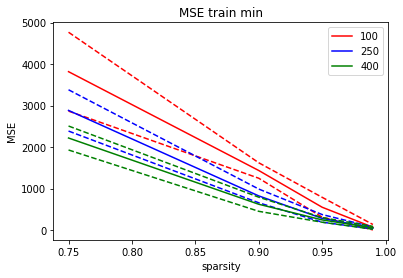

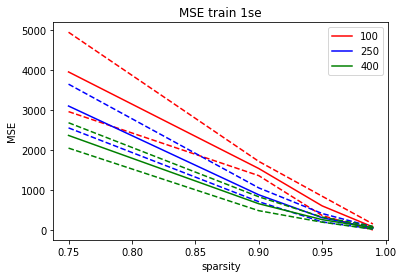

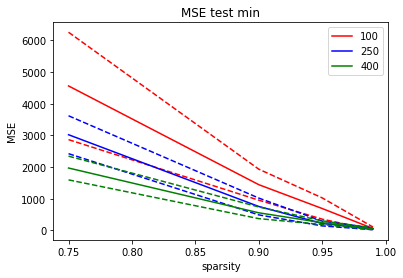

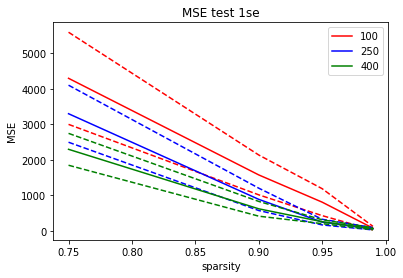

In [5]:
# train data
# vet inte riktigt hur man ska plotta det här på ett tydligt sätt
# kanske kolla om hon har gjort något i hennes lectures. Kanske går
# att se om jag är rätt ute eller inte
c = ['red', 'blue', 'green']
t = ['min', '1se']
for ci, ct in enumerate(t):
    plt.figure(ci)
    for i in range(len(n)):
        min_means = np.mean(MSEtrain[ct][i], axis=1)
        min_std = np.std(MSEtrain[ct][i], axis=1)
        min_stds = [min_means - min_std,
                    min_means + min_std]
        line, = plt.plot(sparsity, min_means, c[i])
        line.set_label(int((n[i])))
        plt.plot(sparsity, min_stds[0], c[i], linestyle='dashed')
        plt.plot(sparsity, min_stds[1], c[i], linestyle='dashed')
    plt.title('MSE train ' + ct)
    plt.xlabel('sparsity')
    plt.ylabel('MSE')
    plt.legend()
for ci, ct in enumerate(t):
    plt.figure(ci+2)
    for i in range(len(n)):
        min_means = np.mean(MSEtest[ct][i], axis=1)
        min_std = np.std(MSEtest[ct][i], axis=1)
        min_stds = [min_means - min_std,
                    min_means + min_std]
        line, = plt.plot(sparsity, min_means, c[i])
        line.set_label(int((n[i])))
        plt.plot(sparsity, min_stds[0], c[i], linestyle='dashed')
        plt.plot(sparsity, min_stds[1], c[i], linestyle='dashed')
    plt.title('MSE test ' + ct)
    plt.xlabel('sparsity')
    plt.ylabel('MSE')
    plt.legend()

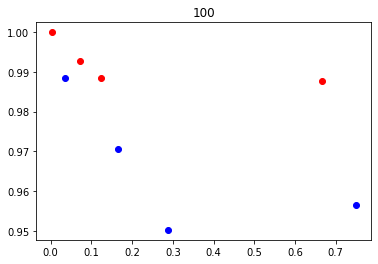

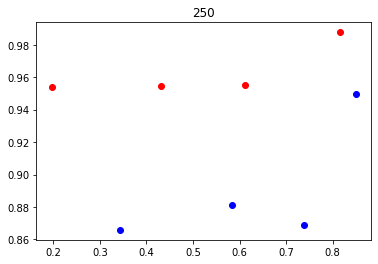

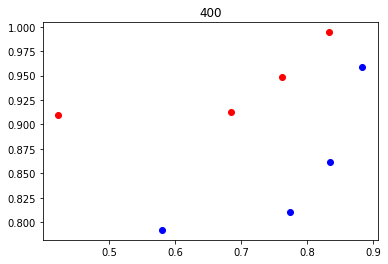

In [6]:
# print(sensitivity)
# print(np.mean(sensitivity['min'][0], axis=1))

# sparsity goes from left to right in the scatter plots i think
# dont know if this should be plotted more clearly
for ci, cn in enumerate(n):
    plt.figure(ci)
    sens_min_means = np.mean(sensitivity['min'][ci], axis=1)
    sens_1se_means = np.mean(sensitivity['1se'][ci], axis=1)
    spec_min_means = np.mean(specificity['min'][ci], axis=1)
    spec_1se_means = np.mean(specificity['1se'][ci], axis=1)
    plt.plot(sens_min_means, spec_min_means, 'o', color='blue')
    plt.plot(sens_1se_means, spec_1se_means, 'o', color='red')
    plt.title(int(cn))


Questions

What differences between sensitivity/specificity computed from the $\lambda_{min}$ and the $\lambda_{1se}$ models can you observe?
- They seem to follow the same kind of curve, 1se always above min

How do different choices for n and sparsity affect the relationship of sensitivity/specificity?
- Higher sparsity seems to push them together, maybe????

## Part 2: Selecting features with confidence

In [7]:
# load the gene expression data set
workload_data_df = pd.read_csv(index_col=0, filepath_or_buffer='data.csv')
labeled_data_df = pd.read_csv(index_col=0, filepath_or_buffer='labels.csv')

In [8]:
n_of_features = 200
variances = workload_data_df.var()
var_lim = 0
ind = []
for i, var in enumerate(variances):
    if var > var_lim:
        ind.append(i)

workload_data_df = workload_data_df.iloc[:, ind]
trimmed_data = SelectKBest(score_func=f_classif, k=n_of_features).fit_transform(workload_data_df, labeled_data_df['Class'])
# workload_data.shape
trimmed_data.shape


(801, 200)

In [9]:
hp = np.logspace(-4, 4, 30)
n_folds = 5

# scoring can be anything from sklearn.metrics
# import sklearn
# sorted(sklearn.metrics.SCORERS.keys())
lr_cv = LogisticRegressionCV(Cs=hp, cv=n_folds, scoring='f1', penalty='l1', 
                        multi_class='ovr', solver='liblinear', intercept_scaling=10000).fit(trimmed_data, labeled_data_df['Class'])


In [10]:
labels = ['PRAD', 'LUAD', 'BRCA', 'KIRC', 'COAD']
C_max_list = []
C_1se_list = []
for cl in labels:
    cv_mean = np.mean(lr_cv.scores_[cl], axis=0)
    cv_std = np.std(lr_cv.scores_[cl], axis=0)
    idx_max_mean = np.argmax(cv_mean)
    idx_1se_mean = np.where(
        (cv_mean <= cv_mean[idx_max_mean] - cv_std[idx_max_mean] / np.sqrt(n_folds)) &
        (cv_mean >= cv_mean[idx_max_mean])
    )[0][0]
    C_max_list.append(lr_cv.Cs_[idx_max_mean])
    C_1se_list.append(lr_cv.Cs_[idx_1se_mean])
    
C_max = max(C_max_list)
C_1se = max(C_1se_list)
# currently the same, might not be werid though?

In [11]:
M = 100
total_selected_features_est = np.zeros([5, 200])
for _ in range(M):
    samples = np.random.choice(range(len(trimmed_data)), len(trimmed_data))
    cb_data = np.array([trimmed_data[dp] for dp in samples])
    cb_labels = np.array([labeled_data_df['Class'][dp] for dp in samples])
    lr = LogisticRegression(C=C_max, penalty='l1', multi_class='ovr', solver='liblinear', intercept_scaling=10000).fit(cb_data, cb_labels)
    beta_est = lr.coef_
    selected_features_est = deepcopy(beta_est)
    for i, _ in enumerate(beta_est):
        non_zero_idx = np.nonzero(beta_est[i])[0]
        selected_features_est[i][non_zero_idx] = 1
    total_selected_features_est += selected_features_est





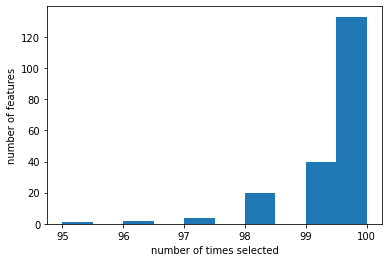

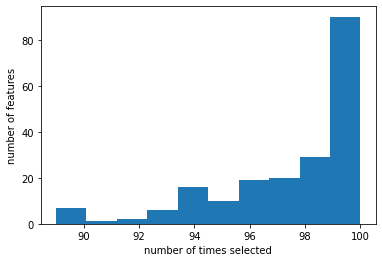

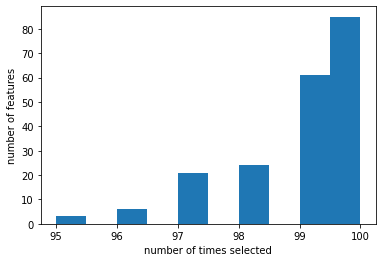

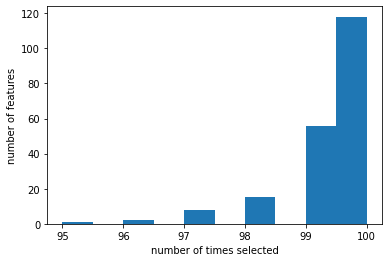

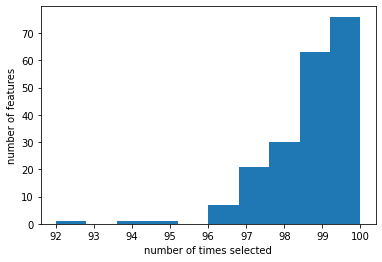

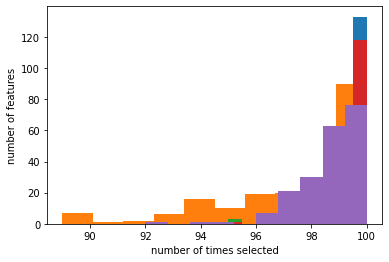

In [12]:
for i in range(len(labels)):
    plt.figure(i)
    plt.hist(total_selected_features_est[i])
    plt.xlabel('number of times selected')
    plt.ylabel('number of features')

for i in range(len(labels)):
    plt.figure(5)
    plt.hist(total_selected_features_est[i])
    plt.xlabel('number of times selected')
    plt.ylabel('number of features')

Questions

What are the 5 most important features for each class?
- Might have done something wrong since we get that around 50 features gets selected M=50 times. Perhaps the chosen C is wrong.

Are there features that appear often in two or more classes simultaneously?
- Definetely seems like it


## Part 3: Selecting features with confidence - a simulation study

Please look at the demo codes and think about how to generalize your Part 1 code to include feature correlations.

In [13]:
p = 500 # 500
nmin = 100 # 100
nmax = p-nmin
nn = 3# 3
n = np.linspace(nmin, nmax, nn)
sparsity = [0.75, 0.9, 0.95, 0.99]
# sparsity = [0.75]
SNR = 2
beta_scale = 5
print(n)

[100. 250. 400.]


In [16]:
rng = np.random.default_rng()
n_runs = 10
n_folds = 5

X, y, beta = simulate_data(int(cn), p, rng, csparsity, SNR, beta_scale)

hp = np.logspace(-4, 4, 30)
n_folds = 5
# need a good choice of lamdbas, a extract from part 1
lambdas = []

lasso = Lasso(alpha_1se).fit(X, y)



samples = np.random.choice(range(len(X)), len(X))
cb_data = np.array([X[dp] for dp in samples])
cb_labels = np.array([y[dp] for dp in samples])


# M = 100
# total_selected_features_est = np.zeros([5, 200])
# for _ in range(M):
#     samples = np.random.choice(range(len(trimmed_data)), len(trimmed_data))
#     cb_data = np.array([trimmed_data[dp] for dp in samples])
#     cb_labels = np.array([labeled_data_df['Class'][dp] for dp in samples])
#     lr = LogisticRegression(C=C_max, penalty='l1', multi_class='ovr', solver='liblinear', intercept_scaling=10000).fit(cb_data, cb_labels)
#     beta_est = lr.coef_
#     selected_features_est = deepcopy(beta_est)
#     for i, _ in enumerate(beta_est):
#         non_zero_idx = np.nonzero(beta_est[i])[0]
#         selected_features_est[i][non_zero_idx] = 1
#     total_selected_features_est += selected_features_est



[[ 1.14526516  1.51050266  1.31111354 ...  0.69762122 -1.60179006
  -1.55900795]
 [-0.57019803  1.38206436  0.10902151 ... -0.94469717  1.01994104
  -1.04822678]
 [ 0.3657824   2.8071022   0.05380694 ... -1.82424426  0.78044648
  -0.12302695]
 ...
 [ 1.38876569 -0.02158169 -0.89748841 ... -1.53779542  0.45072109
   0.43412591]
 [ 0.30233856  0.24099172 -2.16830498 ... -0.76724894 -0.78762622
   0.45715436]
 [ 1.05969142  0.15443831 -0.01330434 ... -1.4171658  -0.31154284
  -0.13308802]]
[[-0.15995805 -0.10115882 -0.89291095 ... -0.82270078 -1.45865359
   1.81952066]
 [-0.45893938 -0.71344858  0.02453648 ... -0.36606135  1.31932646
  -0.16417669]
 [-0.24235959 -1.01606818 -0.83932349 ...  0.96182911 -1.35067094
  -2.15280899]
 ...
 [-0.4127971   1.20074656  0.57419576 ... -1.02692279 -0.03976542
   0.296612  ]
 [ 0.99476014 -0.64850782  2.5232841  ... -0.67462634  2.18699943
  -0.84539873]
 [ 2.75340363  1.64307393 -1.04491757 ... -1.00633433  0.89615459
  -0.15128712]]


TODO: 
- all plots needs to be better
- maybe plot/visualise the simulated data in part 1